In [1]:
import os
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

# READ FRAMES DATA

In [4]:
# get file names of the frames
col_frames = os.listdir('frames/')

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store the frames
col_images=[]

for i in col_frames:
    # read the frames
    img = cv2.imread('frames/'+i)
    # append the frames to the list
    col_images.append(img)

# OPERATION ON SINGLE FRAME

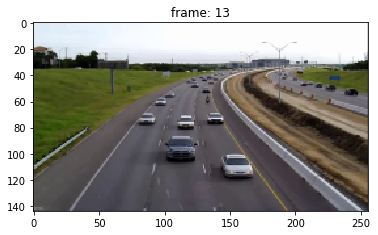

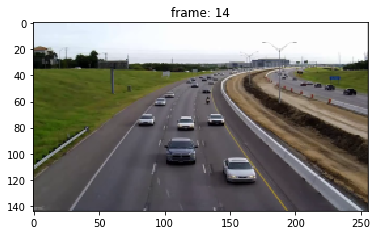

In [6]:
# plot 13th frame
i = 13

for frame in [i, i+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title("frame: "+str(frame))
    plt.show()

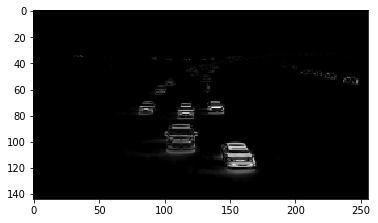

In [7]:
# convert the frames to grayscale
grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap = 'gray')
plt.show()

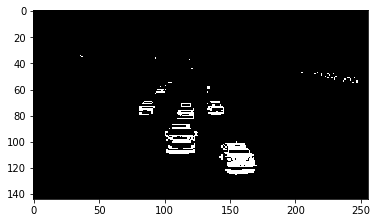

In [8]:
diff_image = cv2.absdiff(grayB, grayA)

# perform image thresholding
ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

# plot image after thresholding
plt.imshow(thresh, cmap = 'gray')
plt.show()

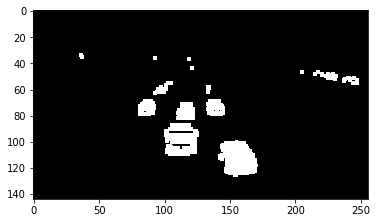

In [9]:
# apply image dilation
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh,kernel,iterations = 1)

# plot dilated image
plt.imshow(dilated, cmap = 'gray')
plt.show()

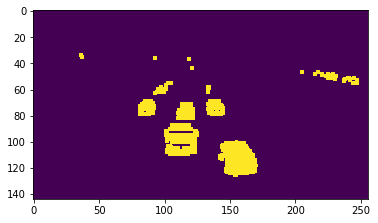

In [10]:
# plot vehicle detection zone
plt.imshow(dilated)
cv2.line(dilated, (0, 80),(256,80),(100, 0, 0))
plt.show()

In [12]:
# find contours
contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

In [13]:
valid_cntrs = []

for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

# count of discovered contours        
len(valid_cntrs)

6

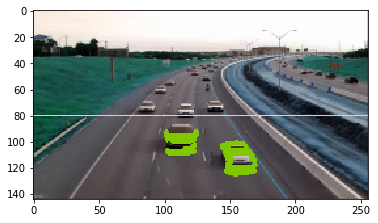

In [14]:
dmy = col_images[13].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
plt.imshow(dmy)
plt.show()

# CREATE FRAMES IN BATCH WITH CONTOURS

In [23]:
# kernel for image dilation
kernel = np.ones((4,4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = "contour_frames_3/"

for i in range(len(col_images)-1):
    
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    
    # image dilation
    dilated = cv2.dilate(thresh,kernel,iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
            if (y >= 90) & (cv2.contourArea(cntr) < 40):
                break
            valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    
    cv2.putText(dmy, "vehicles detected: " + str(len(valid_cntrs)), (55, 15), font, 0.6, (0, 180, 0), 2)
    cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
    cv2.imwrite(pathIn+str(i)+'.png',dmy)

In [24]:
!ls contour_frames_3

0.png   109.png 17.png  28.png  39.png  5.png   60.png  71.png  82.png  93.png
1.png   11.png  18.png  29.png  4.png   50.png  61.png  72.png  83.png  94.png
10.png  110.png 19.png  3.png   40.png  51.png  62.png  73.png  84.png  95.png
100.png 111.png 2.png   30.png  41.png  52.png  63.png  74.png  85.png  96.png
101.png 112.png 20.png  31.png  42.png  53.png  64.png  75.png  86.png  97.png
102.png 113.png 21.png  32.png  43.png  54.png  65.png  76.png  87.png  98.png
103.png 114.png 22.png  33.png  44.png  55.png  66.png  77.png  88.png  99.png
104.png 12.png  23.png  34.png  45.png  56.png  67.png  78.png  89.png
105.png 13.png  24.png  35.png  46.png  57.png  68.png  79.png  9.png
106.png 14.png  25.png  36.png  47.png  58.png  69.png  8.png   90.png
107.png 15.png  26.png  37.png  48.png  59.png  7.png   80.png  91.png
108.png 16.png  27.png  38.png  49.png  6.png   70.png  81.png  92.png


# CONSTRUCT VIDEO FROM FRAMES

In [25]:
# specify video name
pathOut = 'vehicle_detection_v3.mp4'

# specify frames per second
fps = 14.0

In [26]:
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

In [27]:
files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(files)):
    filename=pathIn + files[i]
    
    #read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()

In [30]:
from IPython.display import Video

Video("vehicle_detection_v3.mp4")